# Few Shot Embeddings

This notebook leverages learned features and SVMs to create a few-shot classifier.

## Instantiate Encoder

Let's create our encoders and do preliminary work to process our images.

In [1]:
import torch

from photo_encode.encoder import FaissIndexImageEncoder
from transformers import AutoImageProcessor, AutoModel, ViTImageProcessor, ViTModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# First embedding model: dinov2
processor_dino = AutoImageProcessor.from_pretrained('facebook/dinov2-large')
processor_kwargs_dino = {
    "return_tensors" : "pt"
}

dinov2_hf = AutoModel.from_pretrained('facebook/dinov2-large')

dinov2 = FaissIndexImageEncoder(
    dinov2_hf, 
    index_file_out="./data/test_photos_dinov2.db", 
).eval().to(device)

## Create the Embeddings

Loop over the data with different models and aggregration functions to create our embeddings.

In [3]:
import torch
import os

from tqdm import tqdm

from photo_encode.utils import image_batch_from_folder_generator
from torchvision.transforms import Resize, Compose
from PIL import Image

# Directory with photos
image_folder = "./data/drone_on_truck"

# Batch size
batch_size = 4

# Mean aggregation
def mean_aggregate(x):
    embeddings = x.last_hidden_state
    return embeddings.mean(axis=1)
    
# Walk over the photo directory
with torch.no_grad():
    # For dinov2, we need to override the stack function as the batch collator
    image_paths = []
    labels = []
    class_names = os.listdir(image_folder)
    
    for class_name in class_names:
        class_folder = os.path.join(image_folder, class_name)
        if os.path.isdir(class_folder):
            for image_name in tqdm(os.listdir(class_folder)):
                x = Image.open(os.path.join(class_folder, image_name))
                y = processor_dino(images=x, return_tensors="pt")
                # pixel_values = torch.stack(tuple([y["pixel_values"][0] for y in x]))
                dino_batch = {
                    "pixel_values" : y["pixel_values"].to(device)
                }
                # dinov2_embeddings = dinov2(dino_batch, files, mean_aggregate)
                dinov2_embeddings = dinov2(dino_batch, [os.path.join(class_folder, image_name)], mean_aggregate)
                image_paths.append(os.path.join(class_folder, image_name))
                labels.append(class_name)



100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


## Train SVM

Train the few shot classifier.

In [10]:
import numpy as np

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

label_map = {
    "mounted" : 0,
    "normal_truck" : 1
}

val_split_size=0.1

label_idxs = np.array([label_map[l] for l in labels])

embeddings = dinov2.current_embeddings.cpu().detach().numpy()
len(image_paths)

X_train, X_val, y_train, y_val = train_test_split(embeddings, label_idxs, test_size=val_split_size, stratify=label_idxs)
svm_classifier = svm.SVC(probability=True)
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

accuracy

1.0

normal_truck


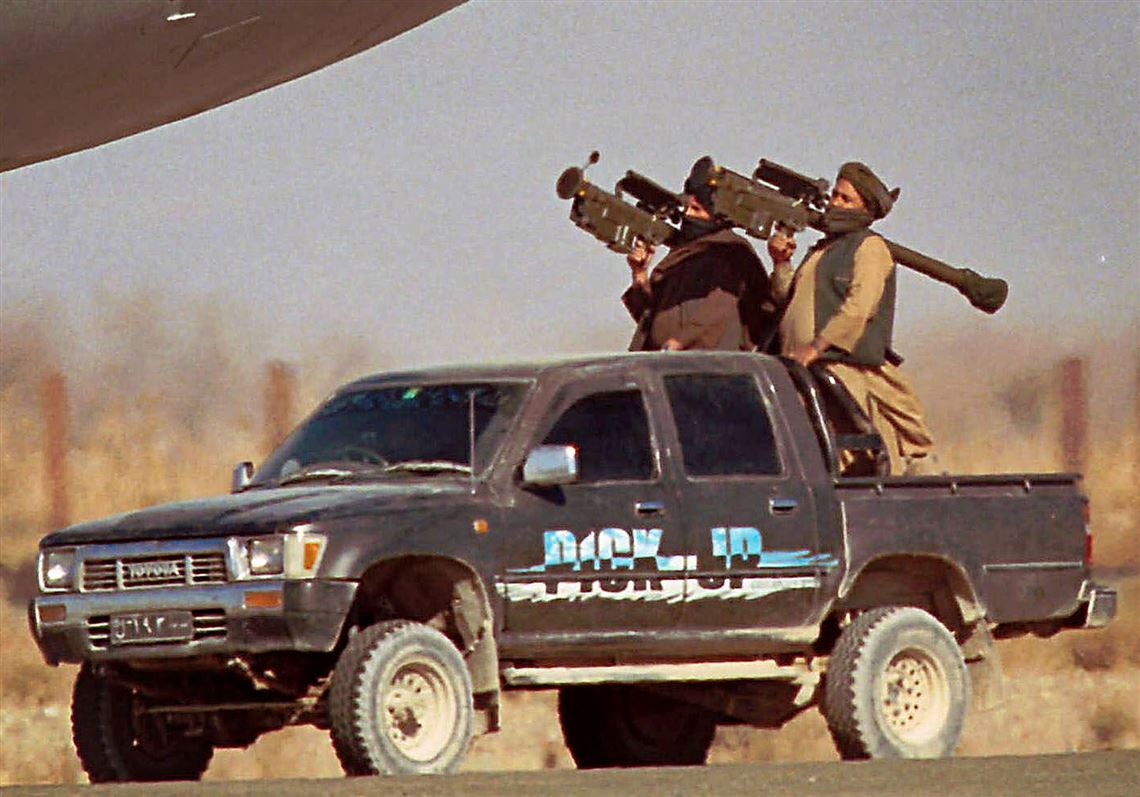

In [41]:
val_img = 3
img = np.where(embeddings == X_val[val_img])[0][0]
pred = svm_classifier.predict([embeddings[img]])

print("mounted" if pred == 0 else "normal_truck")


Image.open(image_paths[img])